# SageMaker/DeepAR demo on Stores Daily Sales

In this lab, we will use Amazon SageMaker build-in algorithm DeepAR to forecast 1604 stores daily sales.

In particular, we will see how to:
* Use the SageMaker Python SDK to train a DeepAR model and deploy it
* Make requests to the deployed model to obtain forecasts interactively
* Illustrate advanced features of DeepAR: additional time features and category information

Running this notebook takes around 40 min on a ml.c4.2xlarge for the training, and inference is done on a ml.m4.xlarge (the usage time will depend on how long you leave your served model running).

For more information see the DeepAR [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html) or [paper](https://arxiv.org/abs/1704.04110), 

In [2]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox

In [3]:
%matplotlib inline

import sys
from urllib.request import urlretrieve
import zipfile
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os

import boto3
import s3fs
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from decouple import config

In [4]:
# set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

In [5]:
sagemaker_session = sagemaker.Session()

Before starting, we can override the default values for the following:
- The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.

In [6]:
s3_bucket = sagemaker.Session().default_bucket()  # replace with an existing bucket if needed
s3_prefix = 'tko-ts-workshop'    # prefix used for all data stored within the bucket

role = sagemaker.get_execution_role()             # IAM role to use by SageMaker

In [7]:
region = sagemaker_session.boto_region_name

s3_data_path = "s3://{}/{}/data".format(s3_bucket, s3_prefix)
s3_output_path = "s3://{}/{}/output".format(s3_bucket, s3_prefix)

Next, we configure the container image to be used for the region that we are running in.

In [8]:
image_name = sagemaker.amazon.amazon_estimator.get_image_uri(region, "forecasting-deepar", "latest")

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


### Import dataset and upload it to S3 to make it available for Sagemaker

We already has pre-processed the data we will use, it is under the same folder.

In [9]:
FILE_NAME = 'data/timeseries_raw.csv'

Then, we load and parse the dataset and convert it to a collection of Pandas time series, which makes common time series operations such as indexing by time periods or resampling much easier. The data has been processed, and the frequency is 1 day.

In [10]:
data = pd.read_csv(FILE_NAME, sep=",", index_col=0, parse_dates=True, decimal=',')
data.index = pd.DatetimeIndex(data.index,freq="1D")

num_timeseries = data.shape[1]

timeseries = []
for i in range(num_timeseries):
    timeseries.append(np.trim_zeros(data.iloc[:,i], trim='f').astype(float))

Let us plot the resulting time series for the first ten stores.

In [11]:
# 2019-07-10 00:00:00 to 2019-10-09 23:59:59

DATETIME_START_OF_TRAIN = config('DATETIME_START_OF_TRAIN')
DATETIME_END_OF_TRAIN = config('DATETIME_END_OF_TRAIN')
DATETIME_START_OF_TEST = config('DATETIME_START_OF_TEST')
DATETIME_END_OF_TEST = config('DATETIME_END_OF_TEST')
DATETIME_START_OF_PREDICT = config('DATETIME_START_OF_PREDICT')
DATETIME_END_OF_PREDICT = config('DATETIME_END_OF_PREDICT')

# we use 1 day frequency for the time series
freq = config('freq')

# we predict for 7 days
prediction_length = config('prediction_length', cast=int)

# we also use 14 days as context length, this is the number of state updates accomplished before making predictions
context_length = config('context_length', cast=int)

sample_sites = config('sample_sites', cast=lambda v: [int(s.strip()) for s in v.split(',')])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNu

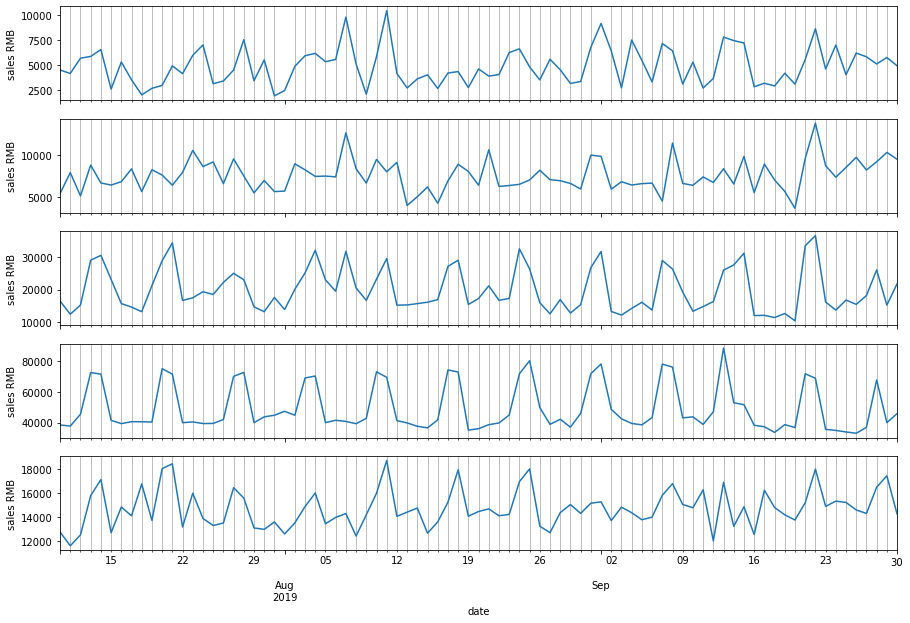

In [12]:
fig, axs = plt.subplots(len(sample_sites), 1, figsize=(15, 10), sharex=True)
axx = axs.ravel()
for i, site in enumerate(sample_sites):
    timeseries[site].loc[DATETIME_START_OF_TRAIN:DATETIME_END_OF_PREDICT].astype(float).plot(ax=axx[i])
    axx[i].set_xlabel("date")    
    axx[i].set_ylabel("sales RMB")   
    axx[i].grid(which='minor', axis='x')

### Train and Test splits

Often times one is interested in evaluating the model or tuning its hyperparameters by looking at error metrics on a hold-out test set. Here we split the available data into train and test sets for evaluating the trained model. For standard machine learning tasks such as classification and regression, one typically obtains this split by randomly separating examples into train and test sets. However, in forecasting it is important to do this train/test split based on time rather than by time series.

In this example, we will reserve the last section of each of the time series for evalutation purpose and use only the first part as training data. 

We specify here the portion of the data that is used for training: the model sees data from 2019-07-10 to 2019-09-16 for training.

In [13]:
start_dataset = pd.Timestamp(DATETIME_START_OF_TRAIN, freq=freq)
end_training = pd.Timestamp(DATETIME_END_OF_TRAIN, freq=freq)
end_test = pd.Timestamp(DATETIME_END_OF_TEST, freq=freq)
start_predict = pd.Timestamp(DATETIME_START_OF_PREDICT, freq=freq)
end_predict = pd.Timestamp(DATETIME_END_OF_PREDICT, freq=freq)

The DeepAR JSON input format represents each time series as a JSON object. In the simplest case each time series just consists of a start time stamp (``start``) and a list of values (``target``). For more complex cases, DeepAR also supports the fields ``dynamic_feat`` for time-series features and ``cat`` for categorical features, which we will use  later.

In [14]:
training_data = [
    {
        "start": str(start_dataset),
        "target": ts[start_dataset:end_training - 1].tolist()  # We use -1, because pandas indexing includes the upper bound 
    }
    for ts in timeseries
]
print(len(training_data))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


1604


As test data, we will consider time series extending beyond the training range: these will be used for computing test scores, by using the trained model to forecast their trailing 7 days, and comparing predictions with actual values.

In [15]:
end_test

Timestamp('2019-09-24 00:00:00', freq='D')

In [16]:
test_data = [
    {
        "start": str(start_dataset),
        "target": ts[start_dataset:end_test - 1].tolist()
    }
    for ts in timeseries
]
print(len(test_data))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


1604


Let's now write the dictionary to the `jsonlines` file format that DeepAR understands (it also supports gzipped jsonlines and parquet).

In [17]:
def write_dicts_to_file(path, data):
    with open(path, 'wb') as fp:
        for d in data:
            fp.write(json.dumps(d).encode("utf-8"))
            fp.write("\n".encode('utf-8'))

In [18]:
%%time
write_dicts_to_file("data/train.json", training_data)
write_dicts_to_file("data/test.json", test_data)

CPU times: user 91.7 ms, sys: 3.93 ms, total: 95.6 ms
Wall time: 95.3 ms


Now that we have the data files locally, let us copy them to S3 where DeepAR can access them. Depending on your connection, this may take a couple of minutes.

In [19]:
s3 = boto3.resource('s3')
def copy_to_s3(local_file, s3_path, override=False):
    assert s3_path.startswith('s3://')
    split = s3_path.split('/')
    bucket = split[2]
    path = '/'.join(split[3:])
    buk = s3.Bucket(bucket)
    
    if len(list(buk.objects.filter(Prefix=path))) > 0:
        if not override:
            print('File s3://{}/{} already exists.\nSet override to upload anyway.\n'.format(s3_bucket, s3_path))
            return
        else:
            print('Overwriting existing file')
    with open(local_file, 'rb') as data:
        print('Uploading file to {}'.format(s3_path))
        buk.put_object(Key=path, Body=data)

In [20]:
%%time
copy_to_s3("data/train.json", s3_data_path + "/train/train.json")
copy_to_s3("data/test.json", s3_data_path + "/test/test.json")

Uploading file to s3://sagemaker-cn-north-1-346044390830/tko-ts-workshop/data/train/train.json
Uploading file to s3://sagemaker-cn-north-1-346044390830/tko-ts-workshop/data/test/test.json
CPU times: user 32.5 ms, sys: 7.6 ms, total: 40.1 ms
Wall time: 298 ms


Let's have a look to what we just wrote to S3.

In [21]:
s3filesystem = s3fs.S3FileSystem()
with s3filesystem.open(s3_data_path + "/train/train.json", 'rb') as fp:
    print(fp.readline().decode("utf-8")[:100] + "...")

{"start": "2019-07-10 00:00:00", "target": [14.0, 18.0, 22.4, 28.5, 25.0, 7.3, 31.1, 0.0, 27.6, 46.1...


We are all set with our dataset processing, we can now call DeepAR to train a model and generate predictions.

### Train a model

Here we define the estimator that will launch the training job.

In [23]:
sagemaker_session = sagemaker.Session()
image_name = sagemaker.amazon.amazon_estimator.get_image_uri(region, "forecasting-deepar", "latest")

role = sagemaker.get_execution_role()             # IAM role to use by SageMaker

estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_uri=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    base_job_name='deepar-stores-sales-demo',
    output_path=s3_output_path
)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Next we need to set the hyperparameters for the training job. For example frequency of the time series used, number of data points the model will look at in the past, number of predicted data points. The other hyperparameters concern the model to train (number of layers, number of cells per layer, likelihood function) and the training options (number of epochs, batch size, learning rate...). We use default parameters for every optional parameter in this case (you can always use [Sagemaker Automated Model Tuning](https://aws.amazon.com/blogs/aws/sagemaker-automatic-model-tuning/) to tune them).

In [24]:
hyperparameters = {
    "time_freq": freq,
    "epochs": "400",
    "early_stopping_patience": "40",
    "mini_batch_size": "32",
    "learning_rate": "5E-4",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length)
}

In [25]:
estimator.set_hyperparameters(**hyperparameters)

We are ready to launch the training job. SageMaker will start an EC2 instance, download the data from S3, start training the model and save the trained model.

If you provide the `test` data channel as we do in this example, DeepAR will also calculate accuracy metrics for the trained model on this test. This is done by predicting the last `prediction_length` points of each time-series in the test set and comparing this to the actual value of the time-series. 

**Note:** the next cell may take a few minutes to complete, depending on data size, model complexity, training options.

In [26]:
%%time
data_channels = {
    "train": "{}/train/".format(s3_data_path),
    "test": "{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels, wait=True)

2021-04-13 04:57:07 Starting - Starting the training job...
2021-04-13 04:57:30 Starting - Launching requested ML instances.........
2021-04-13 04:58:39 Starting - Preparing the instances for training......
2021-04-13 04:59:56 Downloading - Downloading input data...
2021-04-13 05:00:33 Training - Downloading the training image..Arguments: train
[04/13/2021 05:00:50 INFO 140529284842880] Reading default configuration from /opt/amazon/lib/python3.6/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likelihood': 'student-t', 'mini_batch_size': '128', 'num_cells': '40', 'num_dynamic_feat': 'auto', 'num_eval_samples': '100', 'num_layers': '2', 'test_quantiles': '[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]'}
[04/13/2021 05:00:50 INFO 140529284842880] Mergi

Since you pass a test set in this example, accuracy metrics for the forecast are computed and logged (see bottom of the log).
You can find the definition of these metrics from [our documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html). You can use these to optimize the parameters and tune your model or use SageMaker's [Automated Model Tuning service](https://aws.amazon.com/blogs/aws/sagemaker-automatic-model-tuning/) to tune the model for you.

### Create endpoint and predictor

Now that we have a trained model, we can use it to perform predictions by deploying it to an endpoint.

**Note: Remember to delete the endpoint after running this experiment. A cell at the very bottom of this notebook will do that: make sure you run it at the end.**

To query the endpoint and perform predictions, we can define the following utility class: this allows making requests using `pandas.Series` objects rather than raw JSON strings.

In [36]:
from sagemaker.serializers import IdentitySerializer

In [37]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):
    
    def __init__(self, *args, **kwargs):
#         super().__init__(*args, content_type=sagemaker.content_types.CONTENT_TYPE_JSON, **kwargs)
        super().__init__(*args, 
                         serializer=IdentitySerializer(content_type="application/json"),
                         **kwargs)
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                num_samples=100, return_samples=False, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        ts -- `pandas.Series` object, the time series to predict
        cat -- integer, the group associated to the time series (default: None)
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        return_samples -- boolean indicating whether to include samples in the response (default: False)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_time = ts.index[-1] + 1
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)
    
    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None)

        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles
        }
        
        http_request_data = {
            "instances": [instance],
            "configuration": configuration
        }
        
        return json.dumps(http_request_data).encode('utf-8')
    
    def __decode_response(self, response, freq, prediction_time, return_samples):
        # we only sent one time series so we only receive one in return
        # however, if possible one will pass multiple time series as predictions will then be faster
        predictions = json.loads(response.decode('utf-8'))['predictions'][0]
        prediction_length = len(next(iter(predictions['quantiles'].values())))
        prediction_index = pd.DatetimeIndex(start=prediction_time, freq=freq, periods=prediction_length)        
        if return_samples:
            dict_of_samples = {'sample_' + str(i): s for i, s in enumerate(predictions['samples'])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(data={**predictions['quantiles'], **dict_of_samples}, index=prediction_index)

    def set_frequency(self, freq):
        self.freq = freq
        
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]        

def series_to_dict(ts, cat=None, dynamic_feat=None):
    """Given a pandas.Series object, returns a dictionary encoding the time series.

    ts -- a pands.Series object with the target time series
    cat -- an integer indicating the time series category

    Return value: a dictionary
    """
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat        
    return obj

Now we can deploy the model and create and endpoint that can be queried using our custom DeepARPredictor class.

In [38]:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    predictor_cls=DeepARPredictor)

---------------!

The class RealTimePredictor has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


### Make predictions and plot results

Now we can use the `predictor` object to generate predictions.

In [39]:
predictor.predict(ts=timeseries[0][start_dataset:end_test-1],quantiles=[0.10, 0.5, 0.90])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  if __name__ == '__main__':
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:22: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.


,0.1,0.5,0.9
2019-09-24,-23.113403,19.265923,65.973511
2019-09-25,-27.542595,14.479571,49.086594
2019-09-26,-20.278811,20.404276,55.948685
2019-09-27,-17.502697,18.958078,49.140556
2019-09-28,-24.291796,16.675251,48.680645
2019-09-29,-14.774632,11.109956,46.623497
2019-09-30,-20.392916,9.677359,36.403214


Below we define a plotting function that queries the model and displays the forecast.

In [40]:
def plot(
    predictor, 
    target_ts, 
    cat=None, 
    dynamic_feat=None, 
    forecast_date=end_training, 
    show_samples=False, 
    plot_history=7 * 12,
    confidence=80
):
    print("calling served model to generate predictions starting from {}".format(str(forecast_date)))
    assert(confidence > 50 and confidence < 100)
    low_quantile = 0.5 - confidence * 0.005
    up_quantile = confidence * 0.005 + 0.5
        
    # we first construct the argument to call our model
    args = {
        "ts": target_ts[:forecast_date],
        "return_samples": show_samples,
        "quantiles": [low_quantile, 0.5, up_quantile],
        "num_samples": 100
    }


    if dynamic_feat is not None:
        args["dynamic_feat"] = dynamic_feat
        fig = plt.figure(figsize=(20, 12))
        ax = plt.subplot(2, 1, 1)
    else:
        fig = plt.figure(figsize=(20, 6))
        ax = plt.subplot(1,1,1)
    
    if cat is not None:
        args["cat"] = cat
        ax.text(0.9, 0.9, 'cat = {}'.format(cat), transform=ax.transAxes)

    # call the end point to get the prediction
    prediction = predictor.predict(**args)

    # plot the samples
    if show_samples: 
        for key in prediction.keys():
            if "sample" in key:
                prediction[key].plot(color='lightskyblue', alpha=0.2, label='_nolegend_')
                
                
    # plot the target
    target_section = target_ts[forecast_date-plot_history:forecast_date+prediction_length]
    target_section.plot(color="black", label='target')
    
    # plot the confidence interval and the median predicted
    ax.fill_between(
        prediction[str(low_quantile)].index, 
        prediction[str(low_quantile)].values, 
        prediction[str(up_quantile)].values, 
        color="b", alpha=0.3, label='{}% confidence interval'.format(confidence)
    )
    prediction["0.5"].plot(color="b", label='P50')
    ax.legend(loc=2)    
    
    # fix the scale as the samples may change it
    ax.set_ylim(target_section.min() * 0.5, target_section.max() * 1.5)
    
    if dynamic_feat is not None:
        for i, f in enumerate(dynamic_feat, start=1):
            ax = plt.subplot(len(dynamic_feat) * 2, 1, len(dynamic_feat) + i, sharex=ax)
            feat_ts = pd.Series(
                index=pd.DatetimeIndex(start=target_ts.index[0], freq=target_ts.index.freq, periods=len(f)),
                data=f
            )
            feat_ts[forecast_date-plot_history:forecast_date+prediction_length].plot(ax=ax, color='g')

We can interact with the function previously defined, to look at the forecast of any customer at any point in (future) time. 

For each request, the predictions are obtained by calling our served model on the fly.

Here we forecast the consumption of an office after week-end (note the lower week-end consumption). 
You can select any time series and any forecast date, just click on `Run Interact` to generate the predictions from our served endpoint and see the plot.

In [41]:
style = {'description_width': 'initial'}

In [42]:
plt.figure(figsize=(15,5))
@interact_manual(
    customer_id=IntSlider(min=0, max=1603, value=120, style=style), 
#     forecast_day= prediction_length,
    confidence=IntSlider(min=60, max=95, value=80, step=5, style=style),
    history_days_plot=IntSlider(min=1, max=50, value=7, style=style),
    show_samples=Checkbox(value=False),
    continuous_update=False
)
def plot_interact(customer_id, confidence, history_days_plot, show_samples):
    plot(
        predictor,
        target_ts=timeseries[customer_id],
        forecast_date= start_predict -1,#end_training + datetime.timedelta(days=forecast_day),
        show_samples=show_samples,
        plot_history=history_days_plot,
        confidence=confidence
    )

<Figure size 1080x360 with 0 Axes>

interactive(children=(IntSlider(value=120, description='customer_id', max=1603, style=SliderStyle(description_…

## Check metrics

In [ ]:
%%time

preds = []
quantiles=[0.10, 0.5, 0.90]

for i, ts_dict in enumerate(timeseries):
    ts = ts_dict[start_dataset:end_test-1]
    if ts.shape[0] == 0:
        preds.append(None)
        continue
    pred = predictor.predict(ts=ts, quantiles=quantiles)
    preds.append(pred)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:22: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:49: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.


In [ ]:
# Write predict result and label data into a csv for later use
df = pd.DataFrame()
for i in range(len(timeseries)):
    y =  timeseries[i][start_predict:end_predict].fillna(0)
    y_hat = preds[i]['0.5']
    dd = pd.DataFrame({'store_id':i,'y_label': y, 'y_pred': y_hat})
    df = pd.concat([df, dd])
df.index.name='date'
df.to_csv("data/deepar-predict-result.csv")

Print sample site stores prediction result, you can print more if you want.

In [ ]:
%%time
from sklearn import metrics

def show_metrics(sample_sites, pred_result, target_quantile='0.5'):
    preds = pred_result
    for i in sample_sites:  # TODO len(timeseries)
        if preds[i] is None:
            continue
        
        s = timeseries[i].fillna(0)
        
        print("i:", i)
        p10 = preds[i]['0.1']
        p90 = preds[i]['0.9']
        y_label =  timeseries[i][start_predict:end_predict].fillna(0)
        y_pred = preds[i][target_quantile]
        if y_label.shape[0] != y_pred.shape[0]:
            continue
        
        print("RMSE:",np.sqrt(metrics.mean_squared_error(y_label, y_pred)))
        print("MAE:",metrics.mean_absolute_error(y_label, y_pred))
        print("Target Mean:",y_label.mean())
        print(pd.DataFrame({'y_pred': y_pred, 'y_label': y_label}))
        plt.figure(figsize=(12,6))
        s.plot(label='target %s'%str(i))
        plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
        y_pred.plot(label='prediction median')
        plt.legend()
        plt.show()

show_metrics(sample_sites, preds, target_quantile='0.5')

# Additional features

We have seen how to prepare a dataset and run DeepAR for a simple example.

In addition DeepAR supports the following features:

* missing values: DeepAR can handle missing values in the time series during training as well as for inference.
* Additional time features: DeepAR provides a set default time series features such as hour of day etc. However, you can provide additional feature time series via the `dynamic_feat` field. 
* generalize frequencies: any integer multiple of the previously supported base frequencies (minutes `min`, hours `H`, days `D`, weeks `W`, month `M`) are now allowed; e.g., `15min`. We already demonstrated this above by using `1D` frequency.
* categories: If your time series belong to different groups (e.g. types of product, regions, etc), this information can be encoded as one or more categorical features using the `cat` field.

We will now demonstrate categories and time features support. For this part we will reuse the stores sales dataset, we get categories of the stores from data owner and crawler weather data from http://lishi.tianqi.com/shenzhen as dynamic time series: 
* weather time series will contain: the high temperature, the low temperature of the day, whether is rainy, whether is sunshine, whether is cloudy;
* besides that, we add addtional time series that whether the day is weekend;
* categories: 1D array for each target series;

dynamic_feat: total 6 dynamic_feat, the high temperature, the low temperature, is_sunshine, is_rain, is_cloudy, is_weekend. As the stores are in the same city, so each store time series will use same dynamic_feat values.

## Prepare dataset

We will read those data as we have prepared in advance. 

cat is stand for category, here it is a one 1d vector for each store time series.

In [ ]:
cat = pd.read_csv('data/cat.csv', sep=",", index_col=0, parse_dates=True)
cat_num_timeseries = cat.shape[0]
cat_timeseries = []
for i in range(cat_num_timeseries):
    cat_timeseries.append(cat.loc[i])

In [ ]:
is_weekend = pd.read_csv('data/is_weekend.csv', sep=",", index_col=0, parse_dates=True)
is_weekend_timeseries = is_weekend.iloc[:,0]
is_weekend_timeseries

In [ ]:
weather = pd.read_csv('data/shenzhen_weather.csv', sep=",", index_col=0, parse_dates=True)
w_num_timeseries = weather.shape[1]
w_timeseries = []
for i in range(w_num_timeseries):
    w_timeseries.append(weather.iloc[:,i])

In [ ]:
train_dynamic_feat= []
for i in range(5):
    train_dynamic_feat.append(w_timeseries[i][start_dataset:end_training -1].tolist())
train_dynamic_feat.append(is_weekend_timeseries[start_dataset:end_training -1].tolist())

In [ ]:
test_dynamic_feat= []
for i in range(5):
    test_dynamic_feat.append(w_timeseries[i][start_dataset:end_test -1].tolist())
test_dynamic_feat.append(is_weekend_timeseries[start_dataset:end_test -1].tolist())

In [ ]:
predict_dynamic_feat= []
for i in range(5):
    predict_dynamic_feat.append(w_timeseries[i][start_dataset:end_predict -1].tolist())
predict_dynamic_feat.append(is_weekend_timeseries[start_dataset:end_predict -1].tolist())

The DeepAR JSON input format represents each time series as a JSON object. In the case each time series consists of a start time stamp (``start``) and a list of values (``target``)as well as ``dynamic_feat`` for time-series features and ``cat`` for categorical features.

In [ ]:
%%time

training_data_new_features = [
    {
        "start": str(start_dataset),
        "target": timeseries[i][start_dataset:end_training -1].tolist(),
        "cat": cat_timeseries[i].tolist(),
        "dynamic_feat": train_dynamic_feat
    }
    for i in range(cat_num_timeseries)
]
print(len(training_data_new_features))

In [ ]:
test_data_new_features = [
    {
        "start": str(start_dataset),
        "target": timeseries[i][start_dataset:end_test -1].tolist(),
        "cat": cat_timeseries[i].tolist(),
        "dynamic_feat": test_dynamic_feat
    }
    for i in range(cat_num_timeseries)
]
print(len(test_data_new_features))

In [ ]:
def check_dataset_consistency(train_dataset, test_dataset=None):
    d = train_dataset[0]
    has_dynamic_feat = 'dynamic_feat' in d
    if has_dynamic_feat:
        num_dynamic_feat = len(d['dynamic_feat'])
    has_cat = 'cat' in d
    if has_cat:
        num_cat = len(d['cat'])
    
    def check_ds(ds):
        for i, d in enumerate(ds):
            if has_dynamic_feat:
                assert 'dynamic_feat' in d
                assert num_dynamic_feat == len(d['dynamic_feat'])
                for f in d['dynamic_feat']:
                    assert len(d['target']) == len(f)
                    
            if has_cat:
                assert 'cat' in d
                assert len(d['cat']) == num_cat
    check_ds(train_dataset)
    if test_dataset is not None:
        
        check_ds(test_dataset)
        
check_dataset_consistency(training_data_new_features, test_data_new_features)

Write the new train and test data to local disk.

In [ ]:
%%time
write_dicts_to_file("data/train_new_features.json", training_data_new_features)
write_dicts_to_file("data/test_new_features.json", test_data_new_features)

Upload the new train and test data to S3 bucket, here we will use new bucket which has a extend name '-new-features' of the bucket name you used in before case.

In [ ]:
%%time

s3_data_path_new_features = "s3://{}/{}-new-features/data".format(s3_bucket, s3_prefix)
s3_output_path_new_features = "s3://{}/{}-new-features/output".format(s3_bucket, s3_prefix)

print('Uploading to S3 this may take a few minutes depending on your connection.')
copy_to_s3("data/train_new_features.json", s3_data_path_new_features + "/train/train_new_features.json", override=True)
copy_to_s3("data/test_new_features.json", s3_data_path_new_features + "/test/test_new_features.json", override=True)

Agagin, let's setup the estimator and hyperparameters, then let's fit it.

In [ ]:
%%time
estimator_new_features = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    base_job_name='deepar-stores-sales-demo',
    output_path=s3_output_path_new_features
)

hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "epochs": "400",
    "learning_rate": "5E-4",
    "mini_batch_size": "32",
    "early_stopping_patience": "40",
    "num_dynamic_feat": "auto",  # this will use the `dynamic_feat` field if it's present in the data
}
estimator_new_features.set_hyperparameters(**hyperparameters)

estimator_new_features.fit(
    inputs={
        "train": "{}/train/".format(s3_data_path_new_features),
        "test": "{}/test/".format(s3_data_path_new_features)
    }, 
    wait=True
)

As before, we spawn an endpoint to visualize our forecasts on examples we send on the fly.

In [ ]:
%%time
predictor_new_features = estimator_new_features.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    predictor_cls=DeepARPredictor)

Now let's use the new predictor to predict the same time series. You can see this time we need pass **cat**, **dynamic_feat** to the predictor.

In [ ]:
store_id = 120
predictor_new_features.predict(
    ts=timeseries[store_id][start_dataset:end_test-1], 
    cat=cat_timeseries[store_id].tolist(),
    dynamic_feat=predict_dynamic_feat, 
    quantiles=[0.1, 0.5, 0.9])

As before, we can query the endpoint to see predictions for arbitrary time series and time points.

In [ ]:
plt.figure(figsize=(20,10))
@interact_manual(
    customer_id=IntSlider(min=0, max=1603, value=120, style=style), 
#     forecast_day=IntSlider(min=0, max=7, value=0,step=1, style=style),
    confidence=IntSlider(min=60, max=95, value=80, step=5, style=style),
    history_days_plot=IntSlider(min=1, max=50, value=7, style=style),
    show_samples=Checkbox(value=False),
    continuous_update=False
)
def plot_interact(customer_id, confidence, history_days_plot, show_samples):
    target = timeseries[customer_id]
    dynamic_feat = predict_dynamic_feat
    cat=cat_timeseries[store_id].tolist()
    plot(
        predictor_new_features,
        target_ts=target,
        forecast_date= start_predict -1,
        cat=cat,
        dynamic_feat=dynamic_feat,
        show_samples=show_samples,
        plot_history=history_days_plot,
        confidence=confidence
    )

## Check metrics

In [ ]:
%%time

preds_new = []
quantiles=[0.10, 0.5, 0.90]

for i, ts_dict in enumerate(timeseries):
    ts = ts_dict[start_dataset:end_test-1]
    if ts.shape[0] == 0:
        preds_new.append(None)
        continue
    cat = cat_timeseries[i].tolist()
    dynamic_feat = predict_dynamic_feat   
    pred = predictor_new_features.predict(ts, cat=cat, dynamic_feat=dynamic_feat, quantiles=quantiles)
    preds_new.append(pred)

In [ ]:
# Write predict result and label data into a csv for later use
df_new = pd.DataFrame()
for i in range(len(timeseries)):
    y =  timeseries[i][start_predict:end_predict].fillna(0)
    y_hat = preds_new[i]['0.5']
    dd = pd.DataFrame({'store_id':i,'y_label': y, 'y_pred': y_hat})
    df_new = pd.concat([df_new, dd])
df_new.index.name='date'
df_new.to_csv("data/deepar-new-features-predict-result.csv")

In [ ]:
%%time

show_metrics( sample_sites, preds_new, target_quantile='0.5')

### Delete endpoints

In [ ]:
predictor.delete_endpoint()

In [ ]:
predictor_new_features.delete_endpoint()